# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Capstone: Non-Personalied Video Games Recommender

### Background and Problem Statement

In the recent decades, recommender systems have been becoming incresingly prevalent in our daily lives. Ranging from e-commerce platforms such as Amazon, ebay, as well as online streaming service giants like Spotify and Netflix, these huge corporations are utilising them widely in their applications to suggest products, movies and musics to users. They have been proven to be highly effective in improving user engagement and generating customer satisfaction so as to drive business revenue and growth. These intelligent systems typically rely on a combination of user feedback data such as ratings, reviews, purchase history, as well as contextual information such as time duration, location and social networks in order to accurately predict user behaviors.

Singapore’s esports sector is a rising industry due to its huge market growth during the Covid-19 pandemic, with much growth potential to emerge as the leader in the South East Asian region. Its revenue figure is projected to hit US$1.3billion by 2023. With the abundance of options in online platforms due to numerous amounts of new games released each year, this has led to users experiencing difficulties in finding the right choice of games that aligns well to their area of interests and preferences. As a Data Scientist employed by a local games developer firm, I am tasked to create a video games recommender system for the company’s database of games that will allow gamers to tap on when patronising our virtual store. To determine the feasibility of the project,  I will be simulating the building of the recommender system model on Steam’s database of game reviews and features by evaluating and validating the algorithm of various models' performance in predicting the user reviews from the selected input features.

To standardise the analysis and model training procedure, all the notebooks will be run on google colab

- The goal of this notebook will be to conduct preliminary exploratory data analysis on the various kaggle datasets and look into how each of these features can impact the users' preference on different games.

- Due to the large size of the recommendations dataset, most of the notebooks will be done on google colab, and the first notebook will done mainly using pyspark. Pyspark is a python API derived from Apache Spark that is used to perform large scale data processing in distributed environment. Ultimately, the recommendations dataset will be scaled down in this notebook in preparation for modelling because of limitations on the local machine

## Import Libraries

In [ ]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=db0e70f5081fffd7a68d994bd2cdea320de26e1b28ff1e03cd3611dcfea8d2a0
  Stored in directory: /root/.cache/pip/wheels/9f/34/a4/159aa12d0a510d5ff7c8f0220abbea42e5d81ecf588c4fd884
Successfully built pyspark


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pyspark.sql import SparkSession
from pyspark.sql.functions import round
from pyspark.sql.functions import col

In [ ]:
import pyspark
print(pyspark.__version__)

3.4.0


In [ ]:
spark = SparkSession.builder.appName('EDA').getOrCreate()

In [ ]:
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark.conf.set("spark.sql.repl.eagerEval.maxNumRows", 20)
spark.conf.set("spark.sql.repl.eagerEval.maxNumColumns", 20)

In [ ]:
%%time
games = spark.read.csv("/content/drive/MyDrive/Steam games dataset/games.csv", header=True, inferSchema=True)
recco = spark.read.csv('/content/drive/MyDrive/Steam games dataset/recommendations.csv', header=True, inferSchema=True)
meta = spark.read.json('/content/drive/MyDrive/Steam games dataset/games_metadata.json')
users = spark.read.csv("/content/drive/MyDrive/Steam games dataset/users.csv", header=True, inferSchema=True)

CPU times: user 514 ms, sys: 67.3 ms, total: 582 ms
Wall time: 1min 22s


In [ ]:
spark

In [ ]:
print('Number of rows in games.csv:', games.count())
print('Number of rows in recommendations.csv:', recco.count())
print('Number of rows in users.csv:', users.count())

Number of rows in games.csv: 46068
Number of rows in recommendations.csv: 10072270
Number of rows in users.csv: 5810794


In [ ]:
print('Number of unique users in users.csv:', users.distinct().count())
print('Number of unique users in recommendations.csv:', users.distinct().count())

Number of unique users in users.csv: 5810794
Number of unique users in recommendations.csv: 5810794


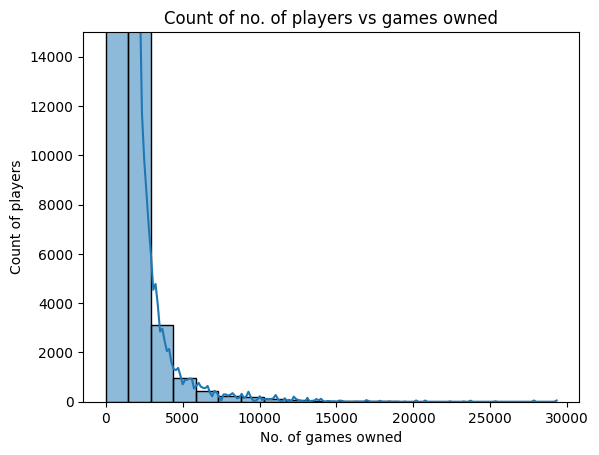

In [ ]:
sns.histplot(data=users.toPandas(), x='products', bins=20, kde=True)
plt.title('Count of no. of players vs games owned')
plt.xlabel('No. of games owned')
plt.ylim((0, 15000))
plt.ylabel('Count of players')
plt.show()

- We see that the distribution is skewed where most players owned < 5000 games, but with a small amount that owned approximately 30000 games

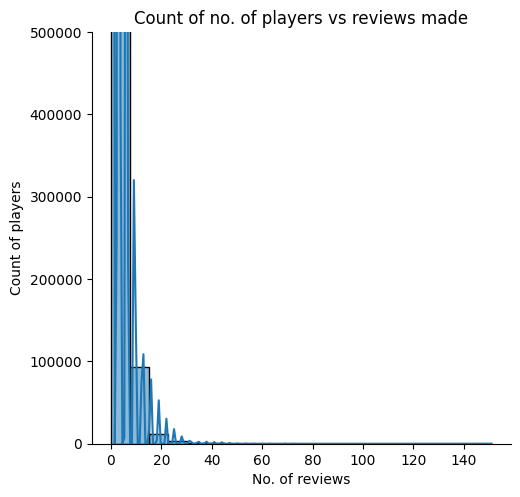

In [ ]:
sns.displot(data=users.toPandas(), x='reviews', bins=20, kde=True)
plt.title('Count of no. of players vs reviews made')
plt.xlabel('No. of reviews')
plt.ylim((0, 500000))
plt.ylabel('Count of players')
plt.show()

- We see that the distribution is skewed where most players do not make many reviews

In [ ]:
users.select(['products', 'reviews']).toPandas().describe()

,products,reviews
count,5.810794e+06,5.810794e+06
mean,1.322544e+02,1.733372e+00
std,2.623620e+02,1.999447e+00
min,0.000000e+00,0.000000e+00
25%,2.300000e+01,1.000000e+00
50%,6.200000e+01,1.000000e+00
75%,1.510000e+02,2.000000e+00
max,2.930800e+04,1.510000e+02


In [ ]:
users.groupby('reviews').agg({'user_id': 'count'}).orderBy('count(user_id)', ascending=False)

reviews,count(user_id)
1,3796875
2,952574
3,377522
4,184308
0,184249
5,102253
6,62287
7,39969
8,27084
9,19137


We filter users' with less than 12 reviews as having them in the dataset will increase the sparsity of the matrix which can possibly introduce noice into our modelling, based on the histogram distribution and review counts

In [ ]:
users = users.filter(users.reviews > 11)

In [ ]:
recco1 = recco.join(users, on='user_id', how='inner')

In [ ]:
recco1.count()

695780

In [ ]:
recco1.dtypes

[('user_id', 'int'),
 ('app_id', 'int'),
 ('helpful', 'int'),
 ('funny', 'int'),
 ('date', 'date'),
 ('is_recommended', 'boolean'),
 ('hours', 'double'),
 ('review_id', 'int'),
 ('products', 'int'),
 ('reviews', 'int')]

In [ ]:
games.columns

['app_id',
 'title',
 'date_release',
 'win',
 'mac',
 'linux',
 'rating',
 'positive_ratio',
 'user_reviews',
 'price_final',
 'price_original',
 'discount',
 'steam_deck']

In [ ]:
games_df = games.join(meta, on="app_id", how="left")

In [ ]:
genre = games_df.toPandas()['tags']
genre[0]

['Action',
 'FPS',
 'Multiplayer',
 'Shooter',
 'Classic',
 'Team-Based',
 'First-Person',
 'Competitive',
 'Tactical',
 "1990's",
 'eSports',
 'PvP',
 'Old School',
 'Military',
 'Strategy',
 'Survival',
 'Score Attack',
 '1980s',
 'Assassin',
 'Nostalgia']

In [ ]:
games_df.toPandas()[['user_reviews', 'positive_ratio', 'price_final', 'price_original', 'discount']].describe()

,user_reviews,positive_ratio,price_final,price_original,discount
count,4.606800e+04,46068.000000,46068.000000,46068.000000,46068.000000
mean,1.843201e+03,76.757988,8.750796,9.299008,5.185291
std,3.908656e+04,18.195317,11.364319,11.668360,18.190569
min,1.000000e+01,0.000000,0.000000,0.000000,0.000000
25%,2.000000e+01,66.000000,1.382500,1.990000,0.000000
50%,5.300000e+01,81.000000,4.990000,5.990000,0.000000
75%,2.260000e+02,91.000000,11.990000,12.990000,0.000000
max,6.941137e+06,100.000000,299.990000,299.990000,90.000000


In [ ]:
#function to sort top n genre
def top_n_genre_sort(df, n):
    genre_list = []
    for i in df:
        for j in i:
            genre_list.append(j)
    genre_df = pd.DataFrame({'genre': genre_list})
    top_n = genre_df.value_counts().sort_values(ascending=False).head(n)
    return top_n

**What is the most common genre across all steam games?**

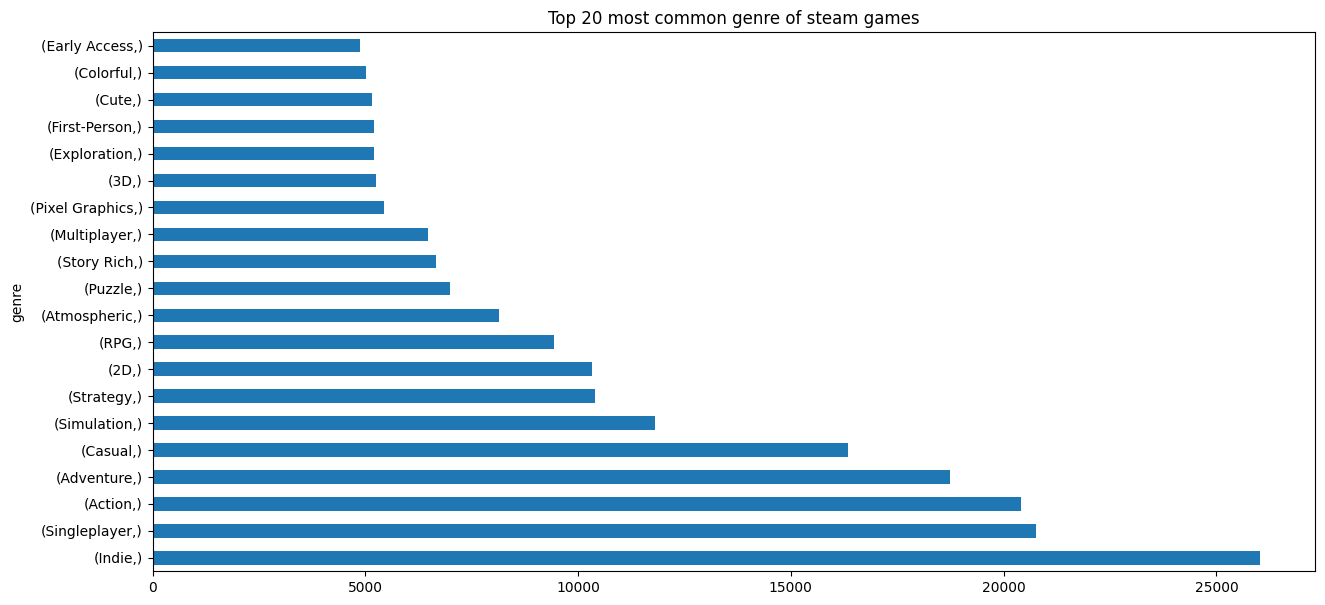

In [ ]:
#top 20 most common genre of steam games
plt.figure(figsize=(15,7))
top_n_genre_sort(genre, 20).plot(kind='barh');
plt.title('Top 20 most common genre of steam games');

Action, Indie, Singleplayer, Adventure, Casual are some of the most common genres of steam games

**What is the most positively reviewed genre across all steam games?**

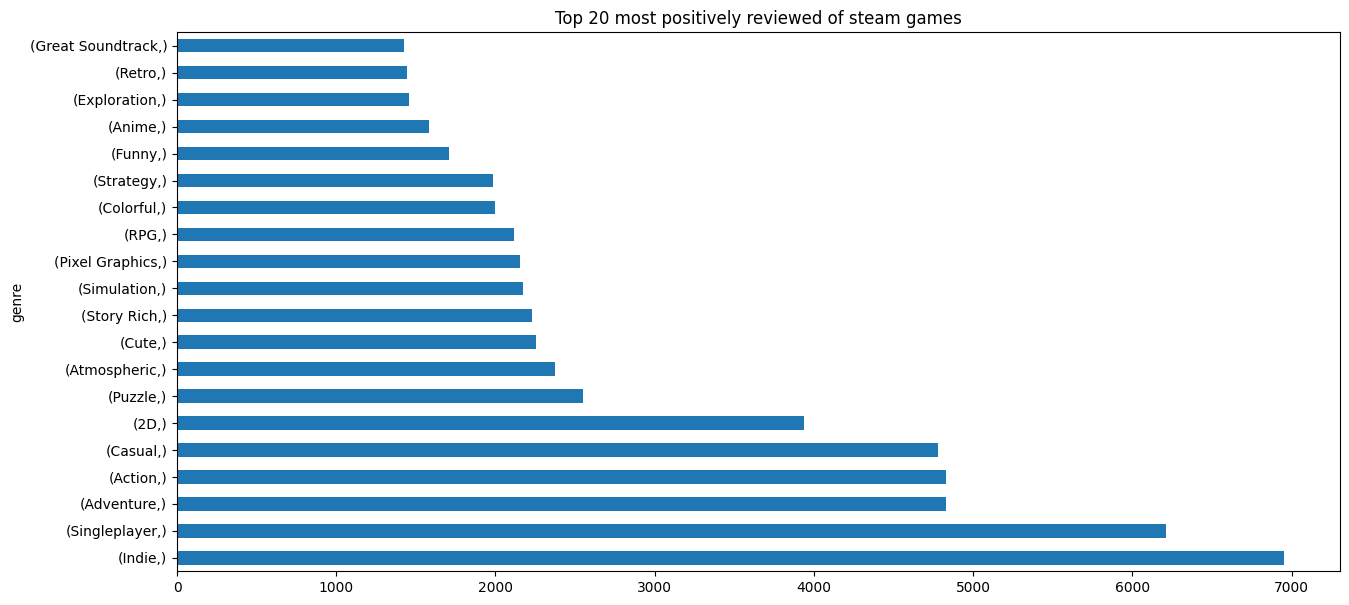

In [ ]:
#top 20 most popular genre of steam games, filtered from 75th percentile
genre_rating = games_df.filter(games_df.positive_ratio >= 91).toPandas()['tags']
plt.figure(figsize=(15,7))
top_n_genre_sort(genre_rating, 20).plot(kind='barh');
plt.title('Top 20 most positively reviewed of steam games');

Action, Indie, Casual, Adventure and Singeplayer are some of the most positively reviewed genres of steam games

**Which genre of games have the most reviews across steam?**

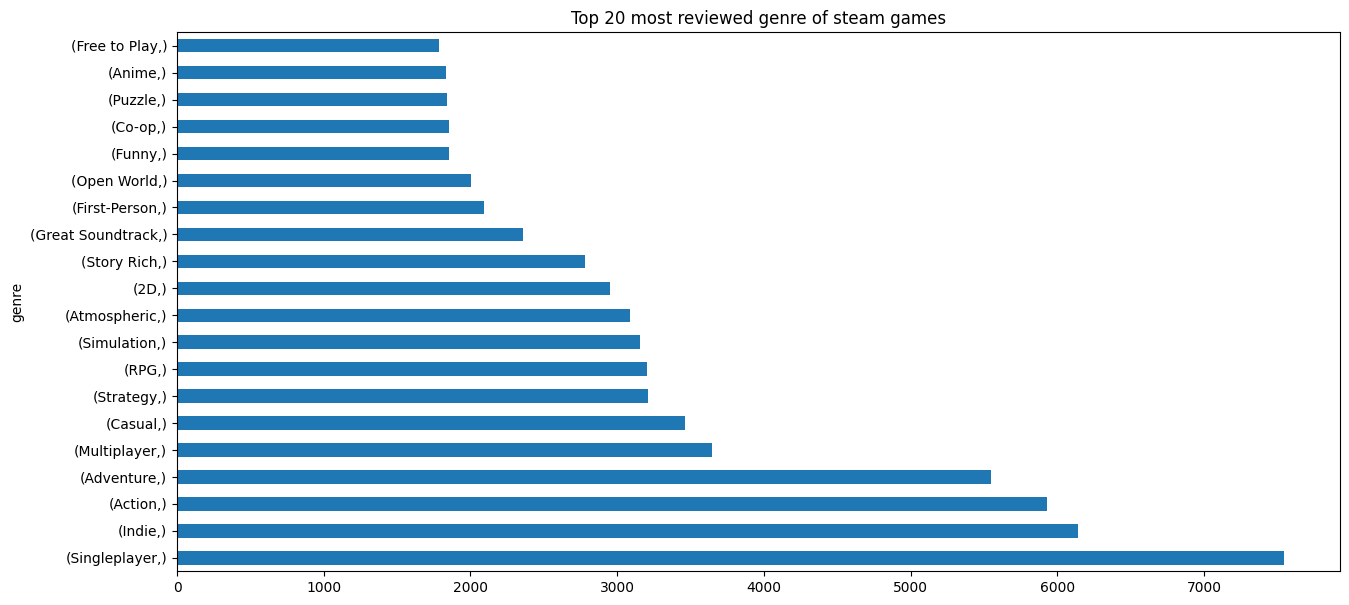

In [ ]:
#top 20 most reviewed genre of steam games
genre_review = games_df.filter(games_df.user_reviews >= 226).toPandas()['tags']
plt.figure(figsize=(15,7))
top_n_genre_sort(genre_review, 20).plot(kind='barh');
plt.title('Top 20 most reviewed genre of steam games');

Action, Multiplayer, Singleplayer, Adventure and Indie based are some of the commonly reviewed genres of steam games

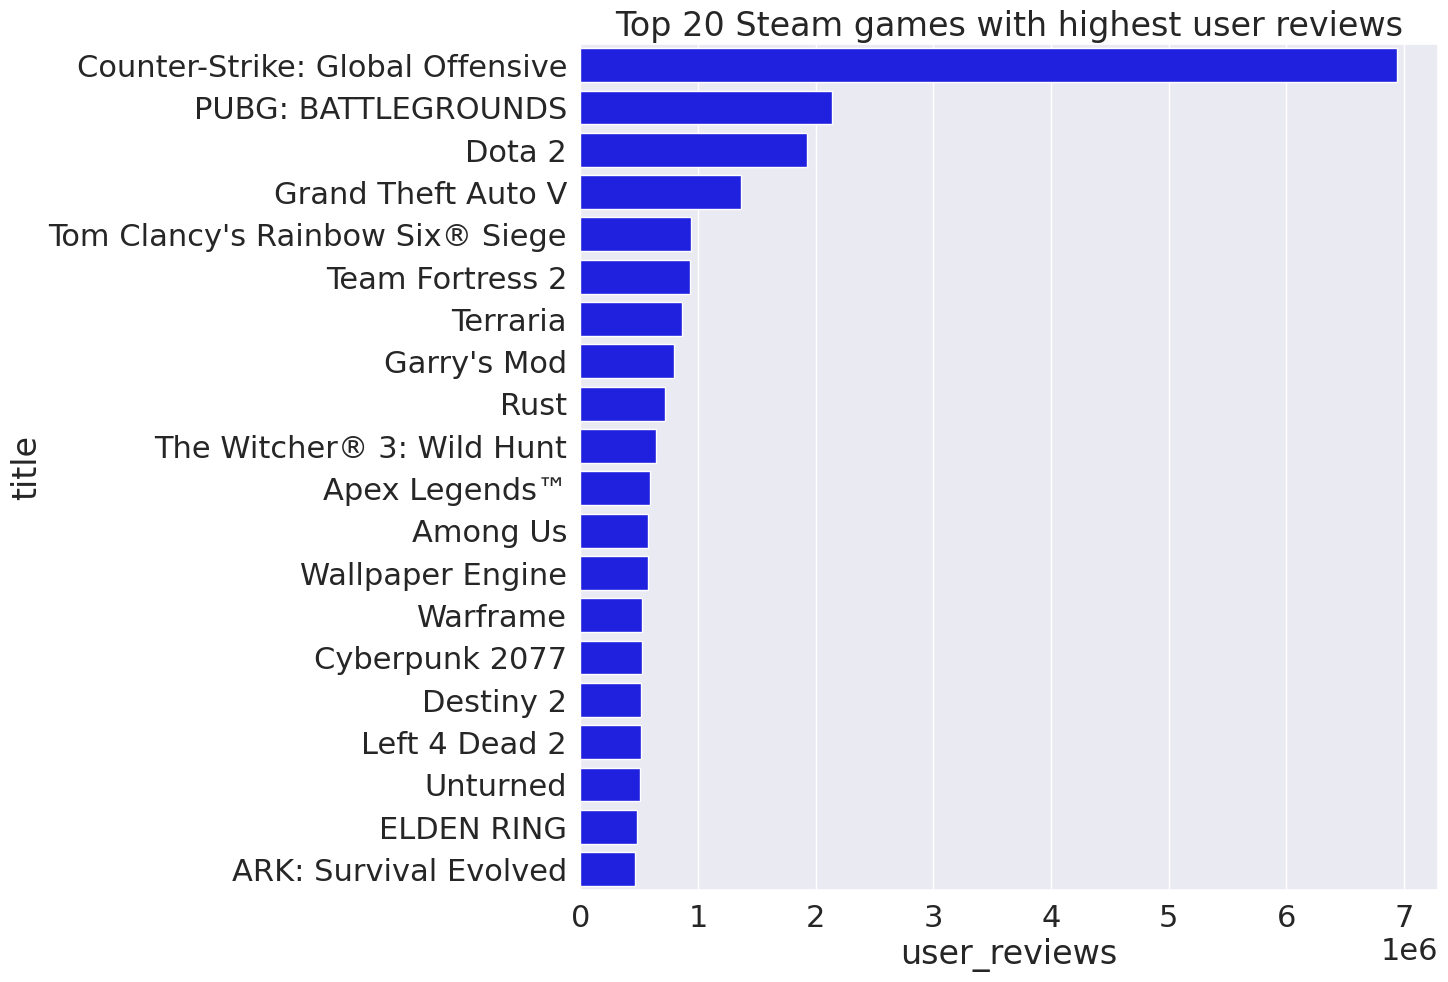

In [ ]:
sns.set(font_scale=2)
plt.figure(figsize=(15,10))
sns.barplot(data=games_df.toPandas().sort_values('user_reviews', ascending=False).head(20), y='title', x='user_reviews', orient='h', color='blue')
plt.tight_layout()
plt.title('Top 20 Steam games with highest user reviews');
plt.show()

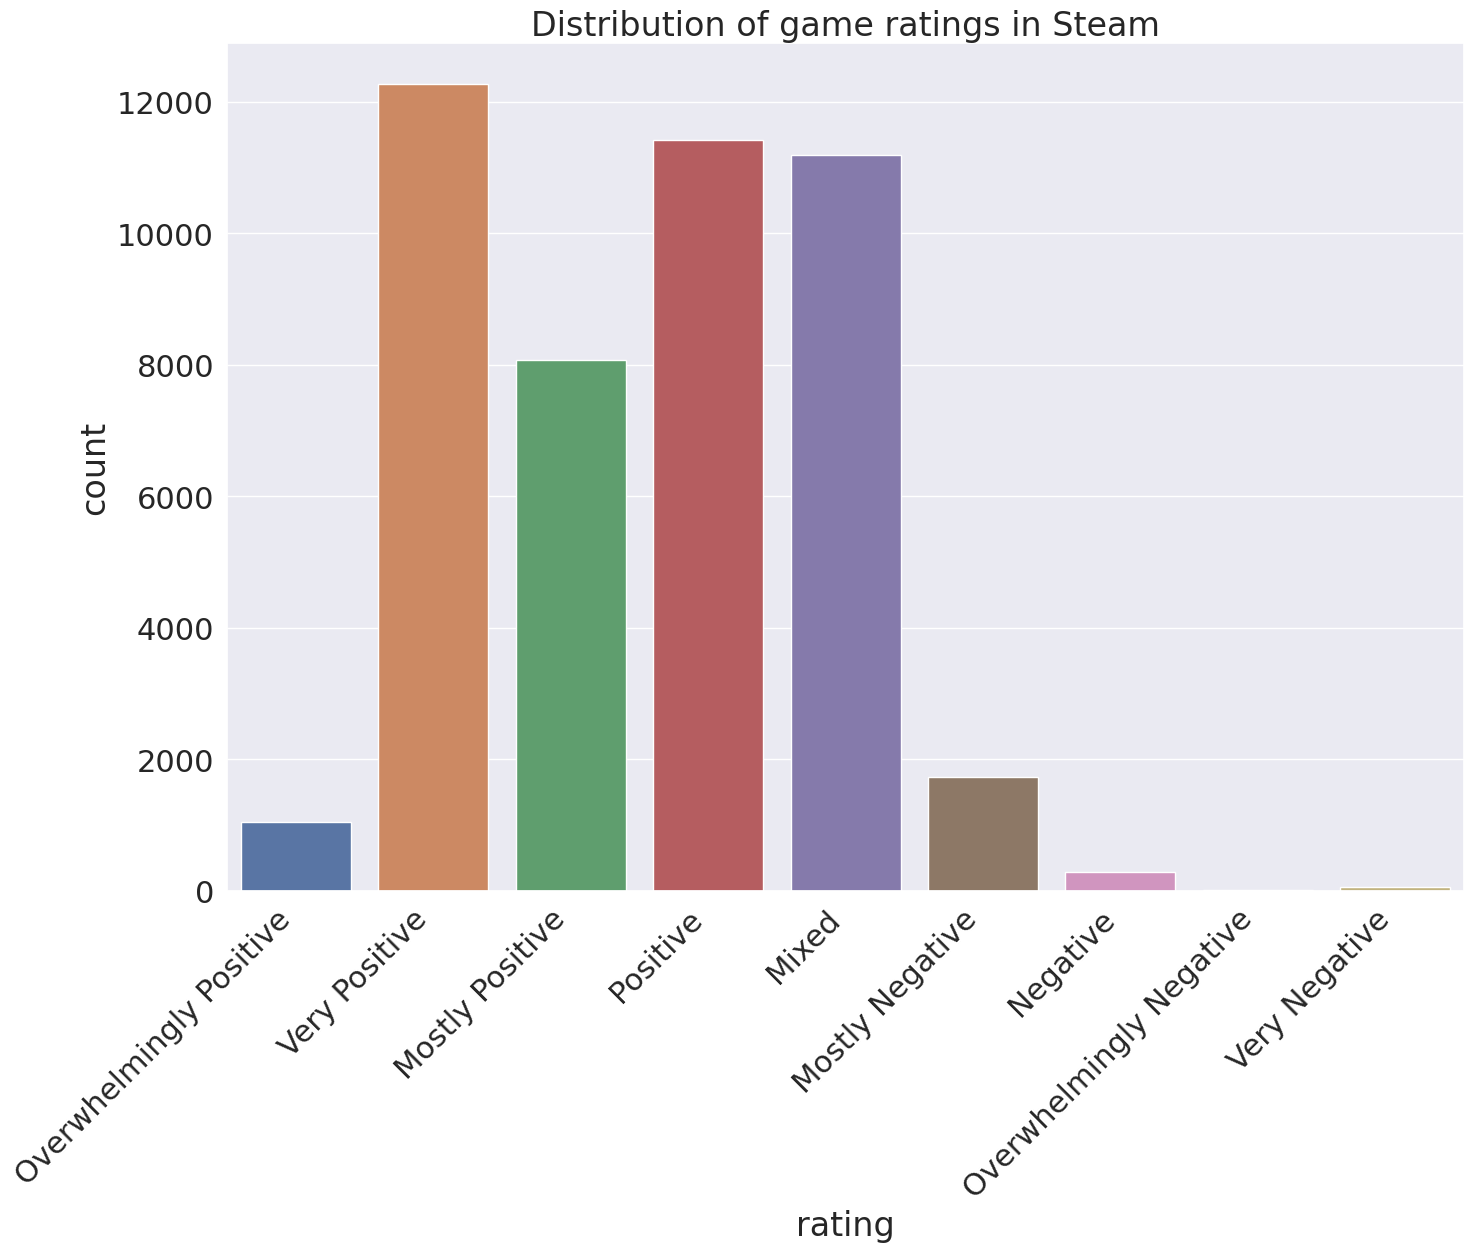

In [ ]:
plt.figure(figsize=(15,10))
sns.countplot(data=games_df.toPandas(), x='rating')
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of game ratings in Steam');
plt.show()

Most of the games in the library are generally reviewed be positive among players based on the distribution

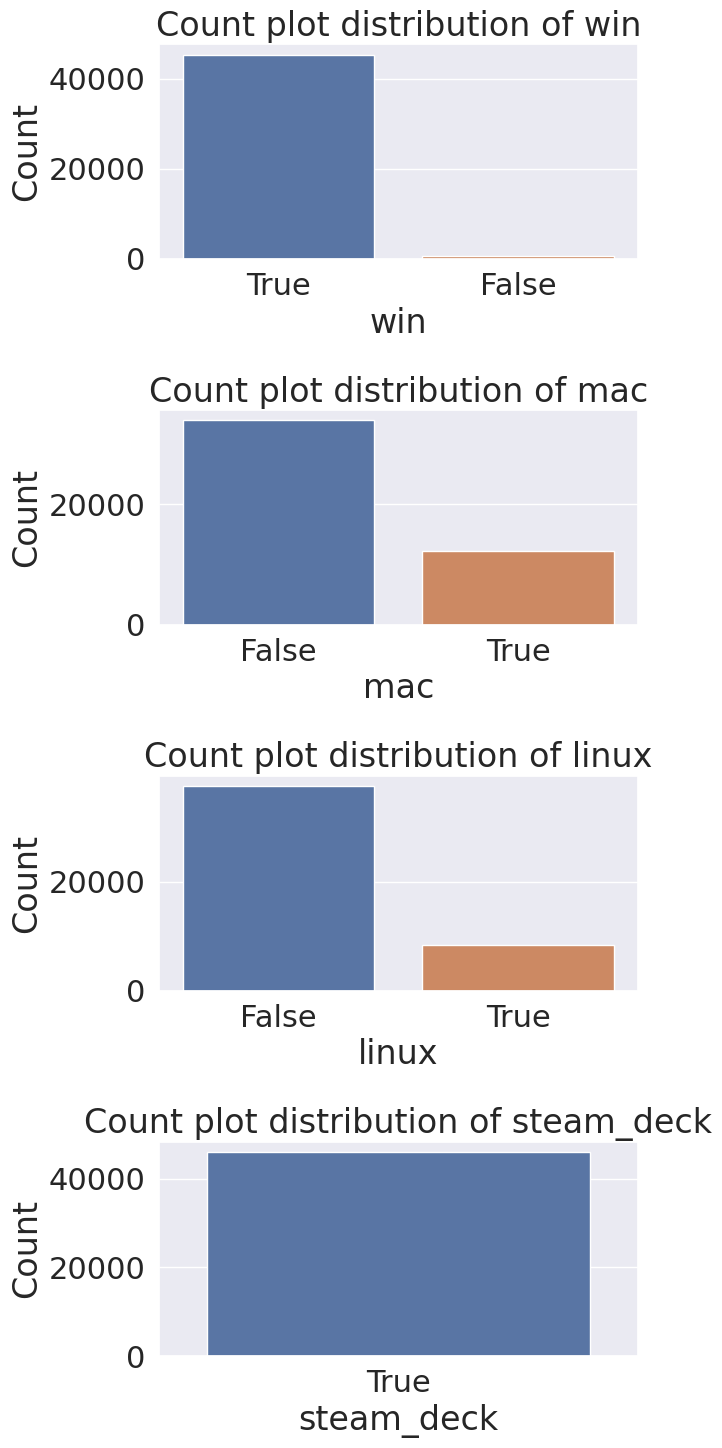

In [ ]:
games_bool = games_df.select(['win', 'mac', 'linux', 'steam_deck'])
#display(recco_bool.take(5))
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(7,15))
games_cols = games_bool.toPandas().astype(str)
#bool_cols = bool_cols.astype(str)
for i, col in enumerate(games_cols.columns):
    sns.countplot(x=col, data=games_cols, ax=axes[i])
    axes[i].set_title(f'Count plot distribution of {col}')
    axes[i].set_xlabel(f'{col}')
    axes[i].set_ylabel(f'Count')
    
plt.tight_layout()
plt.show()   

Most games are not compatible with mac and linux

In [ ]:
def var_hist(df, col, rows, cols, bin):
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 15))
    axes = axes.flatten()
    for i, coln in enumerate(col):
        sns.histplot(x=df[coln], ax=axes[i], bins=bin)
        axes[i].set_title(f'Distribution of {coln}')
        plt.ticklabel_format(style='plain', axis='both')
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.subplots_adjust(hspace=1)
    plt.show()

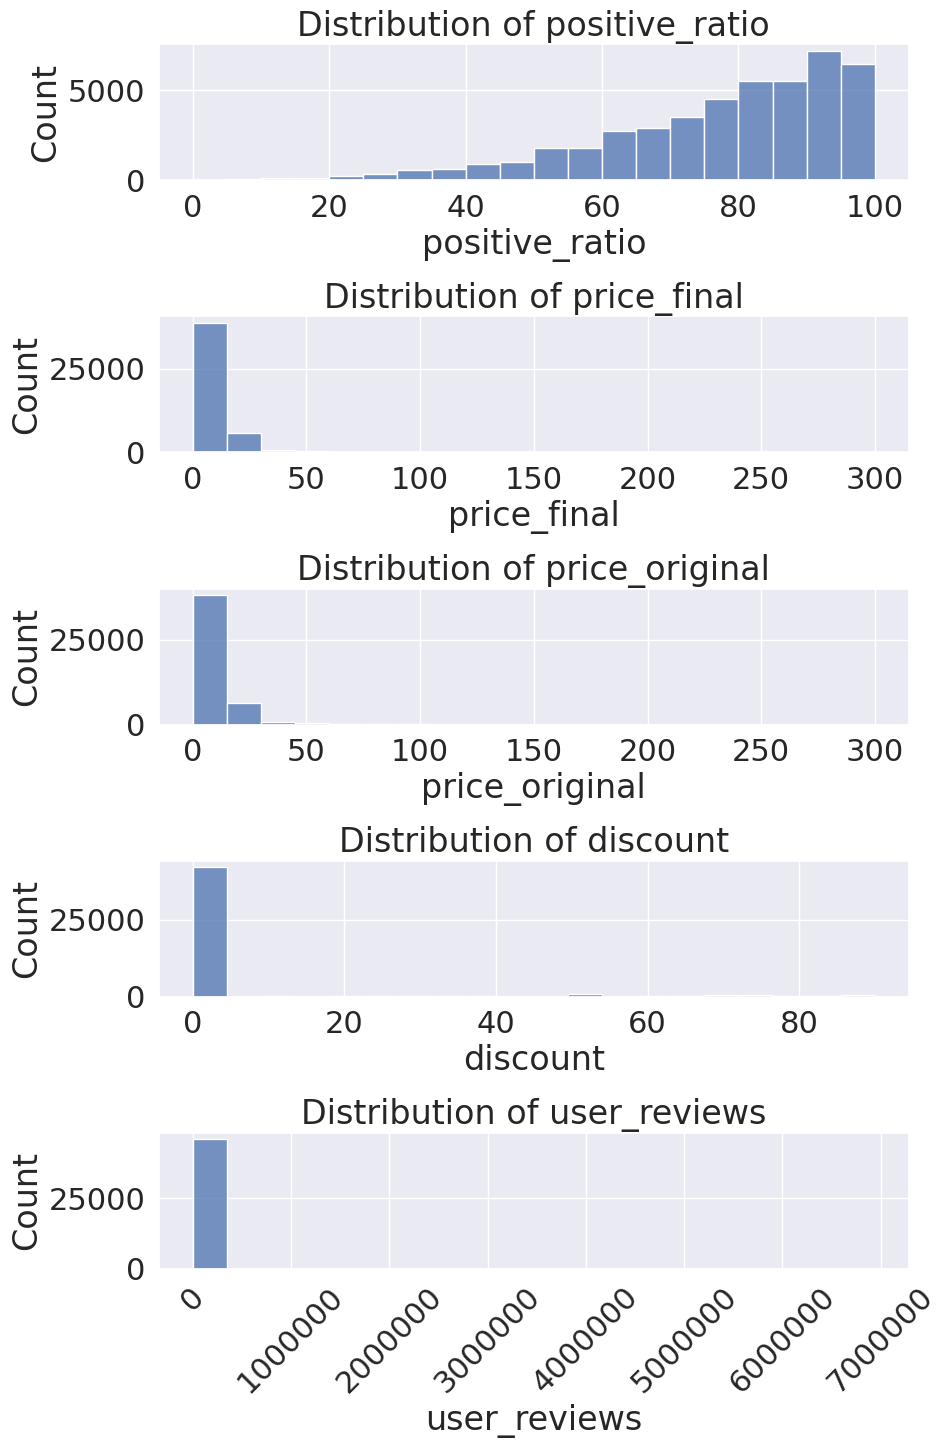

In [ ]:
var_hist(games_df.toPandas(), ['positive_ratio', 'price_final', 'price_original', 'discount', 'user_reviews'], 5, 1, 20)

Most games have been highly rated to be positive with the positive ration being right skewed, and most games do not cost more than 50 dollars. Discounts offered by steam typically do not exceed 10 dollars

In [ ]:
#filter free games as we want to maximise sales profits of games based on our problem statement
#non_negative = ['Overwhelmingly Positive', 'Mostly Positive', 'Very Positive', 'Positive', 'Mixed']
games_df1 = games_df.filter((games_df.price_final > 0)) #& (games_df.rating.isin(non_negative)))
games_df0 = games_df1.orderBy(['user_reviews', 'positive_ratio'], ascending=[False, False])

We filter away free games as we dont want to have our recommendations be based on them, as our goal is to build a recommender system that can bring in sales profits

In [ ]:
games_df0.toPandas()[['user_reviews', 'positive_ratio', 'price_final', 'price_original', 'discount']].describe()

,user_reviews,positive_ratio,price_final,price_original,discount
count,3.875700e+04,38757.000000,38757.000000,38757.000000,38757.000000
mean,1.659239e+03,76.966432,10.401519,11.053144,6.163429
std,3.843316e+04,18.329859,11.676469,11.935037,19.679657
min,1.000000e+01,0.000000,0.270000,0.000000,0.000000
25%,2.000000e+01,67.000000,2.990000,3.990000,0.000000
50%,5.000000e+01,81.000000,6.990000,7.990000,0.000000
75%,2.110000e+02,91.000000,14.990000,14.990000,0.000000
max,6.941137e+06,100.000000,299.990000,299.990000,90.000000


In [ ]:
#filter away reviews from users with 0hrs of gameplay as they do not contribute towards modelling
recco_df = recco1.join(games_df0, on='app_id', how='left')
recco_df = recco_df.filter(recco_df.hours > 0)

We filter away reviews from users with 0 playtime hours as they do not contribute to our modelling

In [ ]:
recco_df = recco_df.dropna(subset=['title'])

In [ ]:
print('Number of reviews: ', recco_df.count())
print('Number of players in reviews set: ', recco_df.select('user_id').distinct().count())
print('Number of games in reviews set: ', recco_df.select('app_id').distinct().count())

Number of reviews:  626490
Number of players in reviews set:  40457
Number of games in reviews set:  625


In [ ]:
recco_df.toPandas().to_parquet('/content/drive/MyDrive/Steam games dataset/recommendations_final.pq', index=False)